In [29]:
import time
import pandas as pd
import numpy as np
import yfinance as yf
from ripser import ripser

TICKER = "SPY"
START = "2000-01-01"
END = pd.Timestamp.today().strftime("%Y-%m-%d")
WINDOW = 120
STEP = 1
OUT_FILE = "ripser_spy_120.csv"

# Download SPY closing prices
data = yf.download(TICKER, start=START, end=END, progress=False)[["Close"]].dropna()
data.sort_index(inplace=True)
results = []
dates = data.index.to_list()

for i in range(0, len(dates) - WINDOW + 1, STEP):
    prices = data["Close"].iloc[i : i + WINDOW].values
    pts = np.column_stack((np.arange(WINDOW), prices))
    t0 = time.perf_counter()
    diagrams = ripser(pts, maxdim=1)["dgms"]
    t1 = time.perf_counter()

    h0 = diagrams[0]
    h1 = diagrams[1]
    lif0 = np.sort(h0[:, 1] - h0[:, 0]) if h0.size else np.array([])
    lif1 = np.sort(h1[:, 1] - h1[:, 0]) if h1.size else np.array([])

    top0 = lif0[-3:][::-1] if lif0.size >= 3 else np.pad(lif0[::-1], (0, 3 - lif0.size))
    top1 = lif1[-3:][::-1] if lif1.size >= 3 else np.pad(lif1[::-1], (0, 3 - lif1.size))

    results.append({
        "start": dates[i].strftime("%Y-%m-%d"),
        "end": dates[i + WINDOW - 1].strftime("%Y-%m-%d"),
        "time_sec": t1 - t0,
        "h0_1": top0[0],
        "h0_2": top0[1],
        "h0_3": top0[2],
        "h1_1": top1[0],
        "h1_2": top1[1],
        "h1_3": top1[2],
    })

df = pd.DataFrame(results)
df.to_csv(OUT_FILE, index=False)
print("Done:", OUT_FILE)

Done: ripser_spy_120.csv


In [30]:
import os
import re
import pandas as pd

# Path to the folder containing the *_bt.txt files
folder = r"c:\Users\User\data\banana_input"
time_pattern = re.compile(r"(\d+)ns")
data = []

for filename in os.listdir(folder):
    if not filename.endswith("_bt.txt"):
        continue

    path = os.path.join(folder, filename)

    # Expect filename like "SPY_w0_bt.txt"
    name_without_suffix = filename[:-7]
    parts = name_without_suffix.split("_w")
    if len(parts) != 2:
        continue

    asset = parts[0]
    try:
        window_start = int(parts[1])
    except ValueError:
        continue

    with open(path, "r") as f:
        lines = f.readlines()

    found_ns = None
    for line in lines:
        match = time_pattern.search(line)
        if match:
            found_ns = int(match.group(1))
            break

    if found_ns is None:
        continue
    time_sec = found_ns / 1e9

    data.append({
        "asset": asset,
        "window_start": window_start,
        "time_ns": found_ns,
        "time_sec": time_sec
    })

df = pd.DataFrame(data)
df = df.sort_values(["asset", "window_start"])
output_file = os.path.join(folder, "banana_tree_summary.csv")
df.to_csv(output_file, index=False)
print(f"Collected {len(df)} records. Saved to:\n  {output_file}")

Collected 896 records. Saved to:
  c:\Users\User\data\banana_input\banana_tree_summary.csv


C:\Users\User\AppData\Local\Temp\ipykernel_4296\3918539472.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


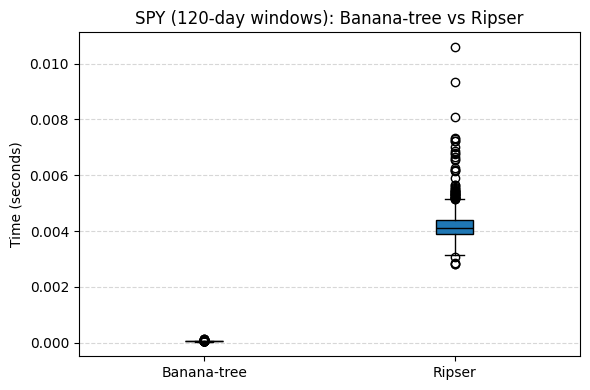

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ripser_path = r"C:\Users\User\ripser_spy_120.csv"
banana_path = r"C:\Users\User\data\banana_input\banana_tree_summary.csv"
ripser_df = pd.read_csv(ripser_path)
ripser_df["window_idx"] = np.arange(len(ripser_df))

#banana-tree results, filter to SPY, sort by window_start
banana_df = pd.read_csv(banana_path)
spy_banana = banana_df[banana_df["asset"] == "SPY"].copy()
spy_banana.sort_values("window_start", inplace=True)
spy_banana.reset_index(drop=True, inplace=True)

#keep only those Ripser rows whose window_idx is in spy_banana.window_start
valid_indices = set(spy_banana["window_start"])
filtered_ripser = ripser_df[ripser_df["window_idx"].isin(valid_indices)].copy()
filtered_ripser.sort_values("window_idx", inplace=True)
filtered_ripser.reset_index(drop=True, inplace=True)

#sizes match
count_banana = len(spy_banana)
count_ripser = len(filtered_ripser)
if count_banana != count_ripser:
    raise RuntimeError(f"Size mismatch: banana={count_banana}, ripser={count_ripser}")

#comparison DataFrame using actual Ripser column names
comparison = pd.DataFrame({
    "window_idx":      spy_banana["window_start"],
    "banana_time_sec": spy_banana["time_sec"],
    "ripser_time_sec": filtered_ripser["time_sec"],
    "h0_top1":         filtered_ripser["h0_1"],
    "h0_top2":         filtered_ripser["h0_2"],
    "h0_top3":         filtered_ripser["h0_3"],
    "h1_top1":         filtered_ripser["h1_1"],
    "h1_top2":         filtered_ripser["h1_2"],
    "h1_top3":         filtered_ripser["h1_3"],
})

#compute difference and ratio
comparison["time_diff"] = comparison["banana_time_sec"] - comparison["ripser_time_sec"]
comparison["time_ratio"] = comparison["banana_time_sec"] / comparison["ripser_time_sec"]

#Banana-tree vs Ripser plot
plt.figure(figsize=(6, 4))
plt.boxplot(
    [comparison["banana_time_sec"], comparison["ripser_time_sec"]],
    labels=["Banana-tree", "Ripser"],
    patch_artist=True,
    medianprops={"color": "black"}
)
plt.ylabel("Time (seconds)")
plt.title("SPY (120-day windows): Banana-tree vs Ripser")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [37]:
csv_path = r"C:\Users\User\data\banana_input\compare_spy_120.csv"
df = pd.read_csv(csv_path)

summary = {
    "statistic": ["count", "25\\%", "50\\%", "75\\%", "max"],
    "banana_time_sec": [
        len(df["banana_time_sec"]),
        df["banana_time_sec"].quantile(0.25),
        df["banana_time_sec"].quantile(0.50),
        df["banana_time_sec"].quantile(0.75),
        df["banana_time_sec"].max()
    ],
    "ripser_time_sec": [
        len(df["ripser_time_sec"]),
        df["ripser_time_sec"].quantile(0.25),
        df["ripser_time_sec"].quantile(0.50),
        df["ripser_time_sec"].quantile(0.75),
        df["ripser_time_sec"].max()
    ]
}
summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

statistic  banana_time_sec  ripser_time_sec
    count       896.000000       896.000000
     25\%         0.000050         0.004062
     50\%         0.000052         0.004224
     75\%         0.000056         0.004322
      max         0.000151         0.008249
